In [8]:
import json
import os
from distutils.dir_util import copy_tree
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K


In [9]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from efficientnet.tfkeras import EfficientNetB0 #EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [10]:
dataset_path = './split_dataset/'

def get_filename_only(file_path):
    file_basename = os.path.basename(file_path)
    filename_only = file_basename.split('.')[0]
    return filename_only

In [11]:
input_size = 128
batch_size_num = 32
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

train_datagen = ImageDataGenerator(
    rescale = 1/255,    #rescale the tensor values to [0,1]
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True
    #save_to_dir = tmp_debug_path
)

val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

val_generator = val_datagen.flow_from_directory(
    directory = val_path,
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = "binary",  #"categorical", "binary", "sparse", "input"
    batch_size = batch_size_num,
    shuffle = True
    #save_to_dir = tmp_debug_path
)

test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    classes=['real', 'fake'],
    target_size = (input_size, input_size),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [12]:
# Train a CNN classifier
efficient_net = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (input_size, input_size, 3),
    include_top = False,
    pooling = 'max'
)



model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 64,activation='relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.add(Flatten())

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [13]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [14]:
# Compile model
model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '.\\tmp_checkpoint'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'best_model.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

# Train network
num_epochs = 20
history = model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)

# print(history.history)

Creating Directory: .\tmp_checkpoint
Epoch 1/20
51/51 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.4859
Epoch 1: val_loss improved from inf to 0.67971, saving model to .\tmp_checkpoint\best_model.h5
51/51 [==============================] - 133s 2s/step - loss: 0.9941 - accuracy: 0.4859 - val_loss: 0.6797 - val_accuracy: 0.5882
Epoch 2/20
51/51 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.5306
Epoch 2: val_loss did not improve from 0.67971
51/51 [==============================] - 120s 2s/step - loss: 0.8181 - accuracy: 0.5306 - val_loss: 0.6831 - val_accuracy: 0.5294
Epoch 3/20
51/51 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.5484
Epoch 3: val_loss did not improve from 0.67971
51/51 [==============================] - 109s 2s/step - loss: 0.7577 - accuracy: 0.5484 - val_loss: 0.6836 - val_accuracy: 0.5343
Epoch 4/20
51/51 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.5447
Epoch 4:

In [15]:
model.evaluate(train_generator)

51/51 [==============================] - 41s 799ms/step - loss: 0.3299 - accuracy: 0.8756


[0.3298722803592682, 0.875612735748291]

In [16]:
model.evaluate(val_generator)

7/7 [==============================] - 4s 594ms/step - loss: 0.7604 - accuracy: 0.6912


[0.7604234218597412, 0.6911764740943909]

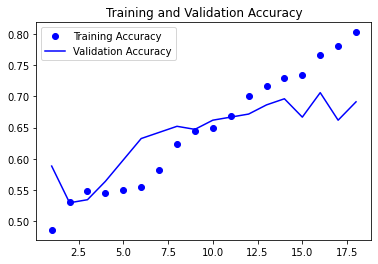

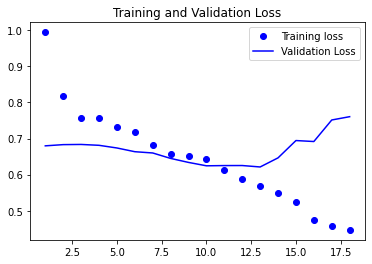

In [17]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
# load the saved model that is considered the best
best_model = load_model(os.path.join(checkpoint_filepath, 'best_model.h5'))

# Generate predictions
test_generator.reset()

preds = best_model.predict(
    test_generator,
    verbose = 1
)

test_results = pd.DataFrame({
    "Filename": test_generator.filenames,
    "Prediction": preds.flatten()
})
print(test_results)

205/205 [==============================] - 7s 29ms/step
                 Filename  Prediction
0     real\real_00026.jpg    0.824252
1     real\real_00036.jpg    0.686093
2     real\real_00037.jpg    0.662277
3     real\real_00044.jpg    0.917898
4     real\real_00051.jpg    0.563627
..                    ...         ...
200  fake\mid_73_1110.jpg    0.699921
201  fake\mid_77_1110.jpg    0.452600
202  fake\mid_85_0011.jpg    0.654686
203  fake\mid_88_1110.jpg    0.258254
204  fake\mid_89_1111.jpg    0.341745

[205 rows x 2 columns]
